In this notebook, we look at how changing parameters of t-distributed stochastic neighbor embedding (t-sne) such as perplexity and number of steps affects the visualisation the chemical space covered by a set of molecules.

In [10]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Set a few parameters to improve the appearance of our plots.

In [2]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Read the input data.

In [3]:
df = pd.read_csv(r"C:\Users\viole\Desktop\Jobs\Metrics\drugbank_all_structure_links\structure_links.csv", dtype={'SMILES': str})
df.shape

(12699, 17)

Take a look at how many rows and columns we have in the data as well as the contesnts of data.

In [4]:
# Remove rows with NaN values in the 'SMILES' column
df = df.dropna(subset=['SMILES'])
print(df.shape)
df.head()

(11925, 17)


DrugBank ID          Name   CAS Number                Drug Groups  \
0     DB00006   Bivalirudin  128270-60-0  approved; investigational   
1     DB00007    Leuprolide   53714-56-0  approved; investigational   
2     DB00014     Goserelin   65807-02-5                   approved   
3     DB00027  Gramicidin D    1405-97-6                   approved   
4     DB00035  Desmopressin   16679-58-6                   approved   

                      InChIKey  \
0  OIRCOABEOLEUMC-GEJPAHFPSA-N   
1  GFIJNRVAKGFPGQ-LIJARHBVSA-N   
2  BLCLNMBMMGCOAS-URPVMXJPSA-N   
3  NDAYQJDHGXTBJL-MWWSRJDJSA-N   
4  NFLWUMRGJYTJIN-PNIOQBSNSA-N   

                                               InChI  \
0  InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...   
1  InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...   
2  InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...   
3  InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...   
4  InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...   

                                              SMILES         Formula  \
0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...   C98H138N24O33   
1  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...    C59H84N16O12   
2  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...    C59H84N18O14   
3  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...   C96H135N19O16   
4  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...  C46H64N14O12S2   

  KEGG Compound ID KEGG Drug ID  PubChem Compound ID  PubChem Substance ID  \
0              NaN       D03136           16129704.0            46507415.0   
1           C07612       D08113                  NaN            46507635.0   
2              NaN       D00573            5311128.0            46507336.0   
3              NaN       D04369           45267103.0            46507412.0   
4           C06944       D00291                  NaN                   NaN   

   ChEBI ID      ChEMBL ID HET ID  ChemSpider ID  BindingDB ID  
0   59173.0  CHEMBL2103749    NaN     10482069.0    50248103.0  
1    6427.0  CHEMBL1201199    NaN       571356.0    50369395.0  
2    5523.0  CHEMBL1201247    NaN      4470656.0           NaN  
3       NaN   CHEMBL557217    NaN     24623445.0           NaN  
4    4450.0     CHEMBL1429    NaN      4470602.0    50205308.0

Look at the first few molecueles in the dataframe.

In [5]:
# Convert SMILES strings to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in df.SMILES]

[19:20:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:20:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:20:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:20:09] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[19:20:09] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[19:20:09] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[19:20:09] Explicit valence for atom # 19 O, 3, is greater than permitted
[19:

C:\Users\viole\anaconda3\Lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


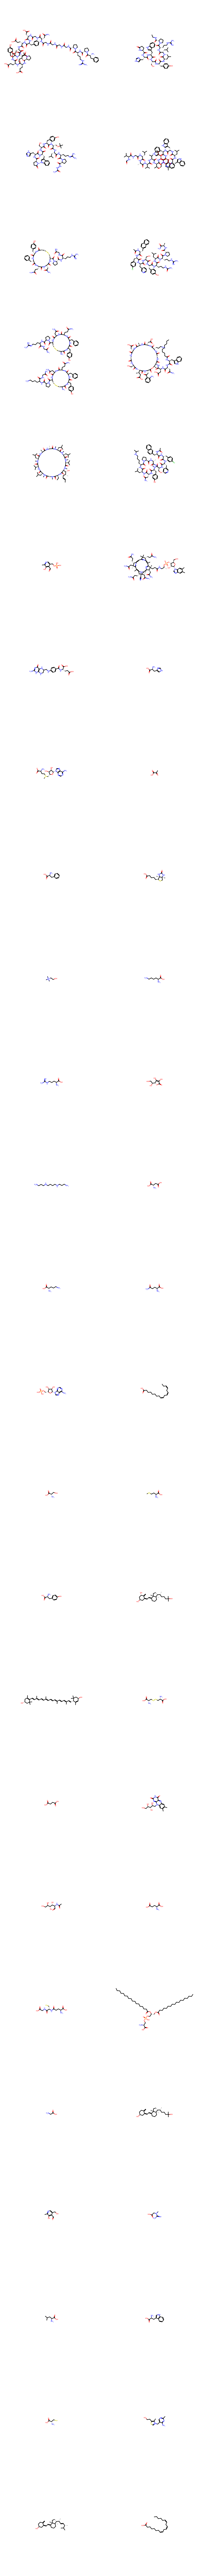

In [6]:
# Use RDKit to draw the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(400, 400))
img

Define a couple of functions to convert a list SMILES to a list of fingerprints.

In [7]:
def avafp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        # Skip NaN or missing values
        if pd.isnull(smiles):
            continue
        # Convert to string if it's not already
        smiles = str(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(avafp_as_array(mol,n_bits))
    return fp_list

def avafp_as_array(mol,n_bits=2048):
    fp = pyAvalonTools.GetAvalonFP(mol, nBits=n_bits)
    arr = np.zeros((1,), np.int64)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [8]:
avafp_list = avafp_list_from_smiles_list(df.SMILES)

  3%|██▍                                                                          | 380/11925 [00:00<00:23, 494.87it/s][19:20:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:20:27] Explicit valence for atom # 0 N, 4, is greater than permitted
 15%|███████████                                                                 | 1734/11925 [00:03<00:16, 602.82it/s][19:20:30] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[19:20:30] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S

Perform principal component analysis (PCA) on the fingerprints.

In [11]:
#Avalon fingerprints
avapca = PCA(n_components=2)
avacrds = avapca.fit_transform(avafp_list)

# Calculate variance explained by each component as a percentage
ava_variance_explained = avapca.explained_variance_ratio_ * 100

# Print the variance explained by each component as a percentage with one decimal point
print("Variance explained by PC1: {:.1f}%".format(ava_variance_explained[0]))
print("Variance explained by PC2: {:.1f}%".format(ava_variance_explained[1]))

Variance explained by PC1: 13.7%
Variance explained by PC2: 6.0%


Check for indole. Put the coordinates from the PCA into a dataframe.

In [13]:
def has_indole(smiles):
    if pd.isnull(smiles):
        return float('nan')
    smiles = str(smiles)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return float('nan')
    indole_pattern = Chem.MolFromSmarts('c1cccc2[nH]ccc12')
    return int(mol.HasSubstructMatch(indole_pattern))

# Assuming df is the DataFrame and 'SMILES' is the column containing SMILES strings. This adds a new column into dataframe indicating indole presence.
df['Has_Indole'] = df['SMILES'].apply(has_indole)
print(df.Has_Indole)

# Sum the 'Has_Indole' column to count the instances of indole
count_has_indole = df['Has_Indole'].sum()

print(f"There are {count_has_indole} instances of indole.")

# Create morcrds_df, avacrds_df, ttocrds_df, maccscrds_df DataFrame
avacrds_df = pd.DataFrame(avacrds,columns=["avaPC_1","avaPC_2"])

# Drop rows with NaN values from 'Has_Indole' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)

# Add the integer values to morcrds_df, avacrds_df, ttocrds_df, maccscrds_df
avacrds_df['Has_Indole'] = has_indole_values.tolist()

# Print the DataFrames
print(avacrds_df.head())

[19:22:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:22:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:22:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:22:01] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[19:22:01] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[19:22:01] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[19:22:02] Explicit valence for atom # 19 O, 3, is greater than permitted
[19:

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
12692    0.0
12693    0.0
12694    0.0
12696    0.0
12697    0.0
Name: Has_Indole, Length: 11925, dtype: float64
There are 331.0 instances of indole.
    avaPC_1   avaPC_2  Has_Indole
0  0.805624  2.128607           0
1  8.233128 -1.444418           1
2  8.922778 -0.207218           1
3  5.426151 -0.086388           1
4  0.289790 -0.578003           0


Check for compounds that have an acyclic saturated chain of C19H39.

[19:50:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:50:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:50:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:50:02] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[19:50:03] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[19:50:03] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[19:50:03] Explicit valence for atom # 19 O, 3, is greater than permitted
[19:

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12692    0.0
12693    0.0
12694    0.0
12696    0.0
12697    0.0
Name: Has_Fragment, Length: 11925, dtype: float64
There are 196.0 instances of chosen fragment.
    avaPC_1   avaPC_2  Has_Indole  Has_Fragment
0  0.805624  2.128607           0             0
1  8.233128 -1.444418           1             0
2  8.922778 -0.207218           1             0
3  5.426151 -0.086388           1             0
4  0.289790 -0.578003           0             0


Text(0.5, 1.0, 'Principal component analysis using Avalon fingerprints')

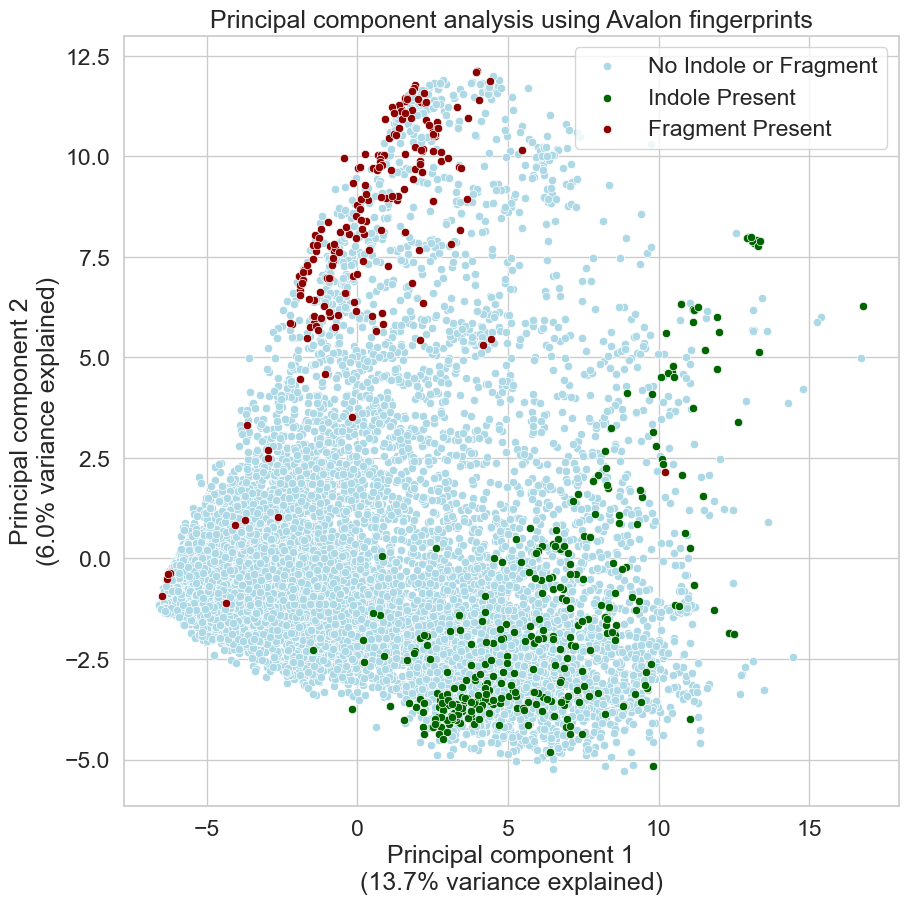

In [63]:
# Fragment

def has_fragment(smiles):
    if pd.isnull(smiles):
        return float('nan')
    smiles = str(smiles)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return float('nan')
    fragment_pattern = Chem.MolFromSmiles('CCCCCCCCCCCCCCCCCCC')
    return int(mol.HasSubstructMatch(fragment_pattern))

# Assuming df is the DataFrame and 'SMILES' is the column containing SMILES strings. Adds a new column into dataframe indicating fragment presence.
df['Has_Fragment'] = df['SMILES'].apply(has_fragment)
print(df.Has_Fragment)

# Sum the 'Has_Naphtalene' column to count the instances of naphtalene
count_has_fragment = df['Has_Fragment'].sum()

print(f"There are {count_has_fragment} instances of chosen fragment.")

# Drop rows with NaN values from 'Has_Fragment' column and convert to integer
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values indicating presence of fragment to dataframes
avacrds_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avacrds_df.head())

# Plot the results
avaax = sns.scatterplot(data=avacrds_df.query("Has_Fragment == 0"),x="avaPC_1",y="avaPC_2",color='lightblue')
avaax = sns.scatterplot(data=avacrds_df.query("Has_Indole == 1"),x="avaPC_1",y="avaPC_2",color='darkgreen')
avaax = sns.scatterplot(data=avacrds_df.query("Has_Fragment == 1"),x="avaPC_1",y="avaPC_2",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present','Fragment Present'])

# Add explained variance ratio next to axes labels
avaax.set_xlabel(f"Principal component 1\n({ava_variance_explained[0]:.1f}% variance explained)")
avaax.set_ylabel(f"Principal component 2\n({ava_variance_explained[1]:.1f}% variance explained)")

# Add title
plt.title('Principal component analysis using Avalon fingerprints')

We will now run t-distributed stochastic neighbor embedding (TSNE) on this dataset.  According to the [sklearn_docs] PCt-sne works much faster with lower dimensional data.  We will use PCA to reduce our dataset to 50 principal components.

CPU times: total: 5min 23s
Wall time: 53.9 s
        avaX       avaY  Has_Indole  Has_Fragment
0 -23.826563  26.412939           0             0
1  55.750832 -76.225006           1             0
2  56.012924 -76.500137           1             0
3  58.062935 -69.880554           1             0
4 -21.019964  24.880743           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


Text(0.5, 1.0, 't-SNE analysis using Avalon fingerprints')

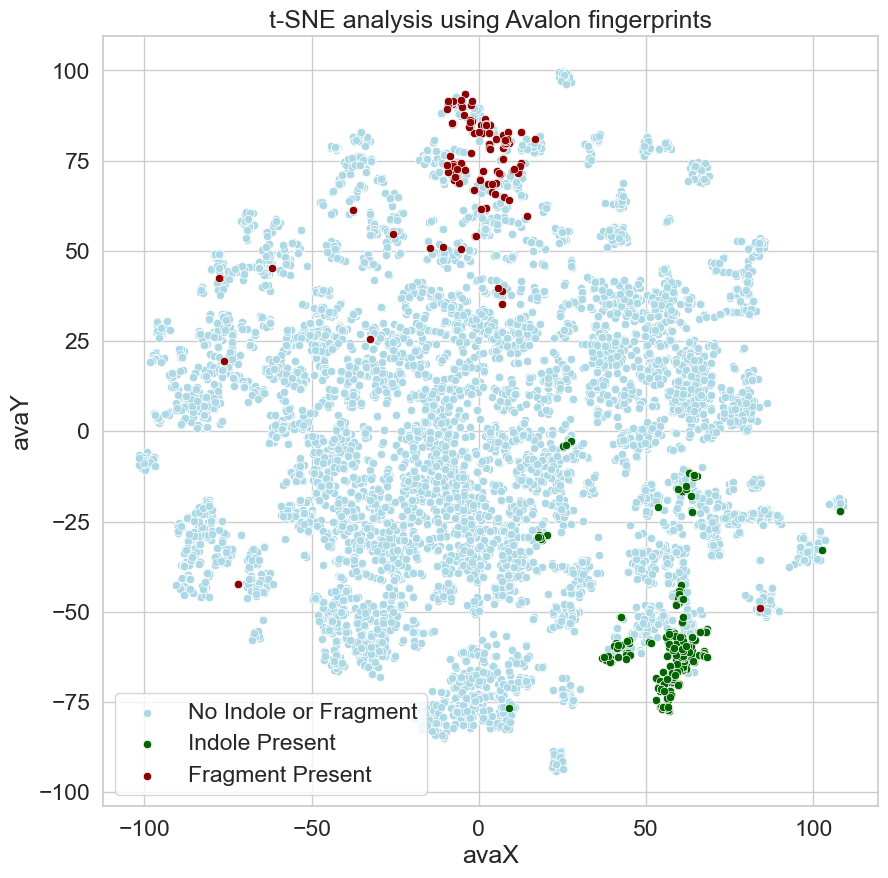

In [64]:
# Use PCA to reduce dataset to 50 principal components
avapca = PCA(n_components=50)
avacrds = avapca.fit_transform(avafp_list)

#Run t-SNE on the 50 principal component database created above
from sklearn.manifold import TSNE
%time avacrds_embedded = TSNE(n_components=2).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Add title
plt.title('t-SNE analysis using Avalon fingerprints')

250 steps.

CPU times: total: 1min 25s
Wall time: 16.4 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -0.930826  0.685657           0             0
1  3.289822 -1.811110           1             0
2  3.288892 -1.812372           1             0
3  3.282987 -1.706176           1             0
4 -0.958397  0.598244           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


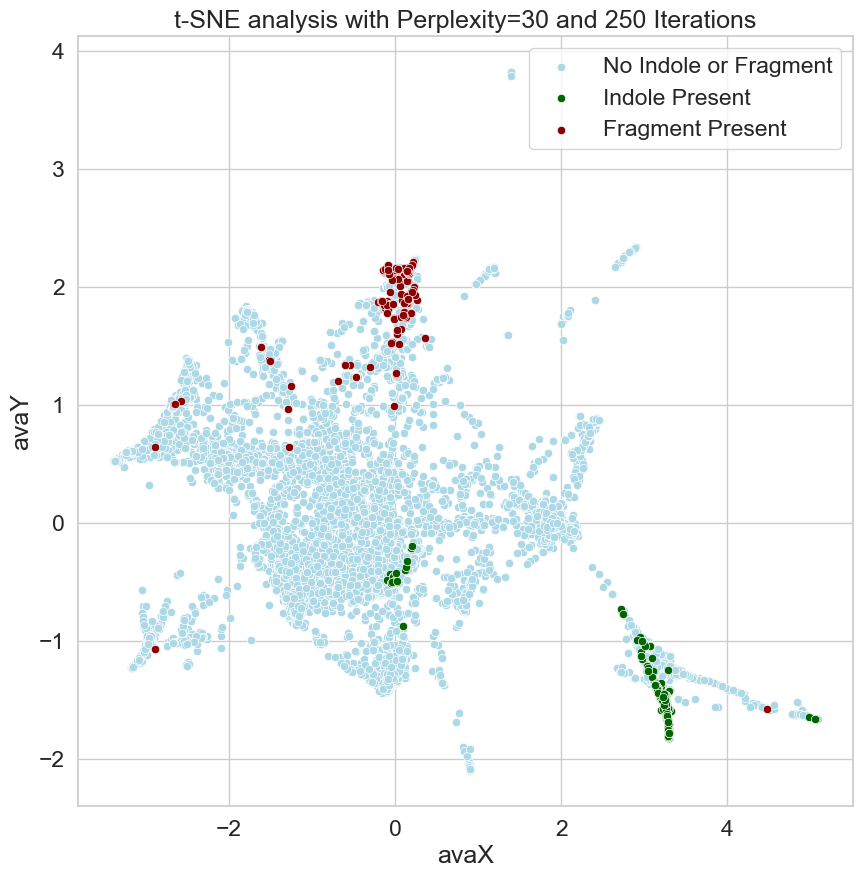

In [76]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

500 steps.

CPU times: total: 2min 36s
Wall time: 29.2 s
        avaX       avaY  Has_Indole  Has_Fragment
0 -11.590646  15.995117           0             0
1  23.968437 -40.040253           1             0
2  24.000830 -40.104595           1             0
3  25.996817 -36.724243           1             0
4 -10.401950  14.768382           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


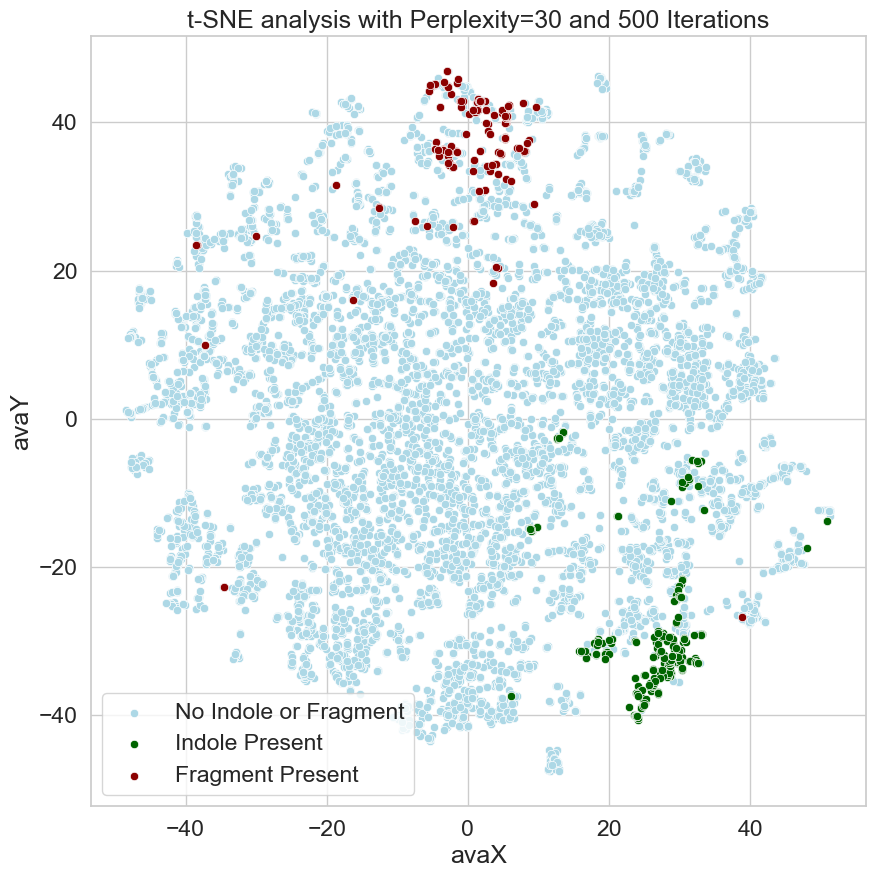

In [77]:
# Desired number of iterations
n_iter_value = 500
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

1000 steps.

CPU times: total: 5min 8s
Wall time: 54.5 s
        avaX       avaY  Has_Indole  Has_Fragment
0 -23.662285  26.826075           0             0
1  55.232906 -77.314171           1             0
2  55.493557 -77.580933           1             0
3  57.670647 -70.873070           1             0
4 -20.921259  25.197994           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


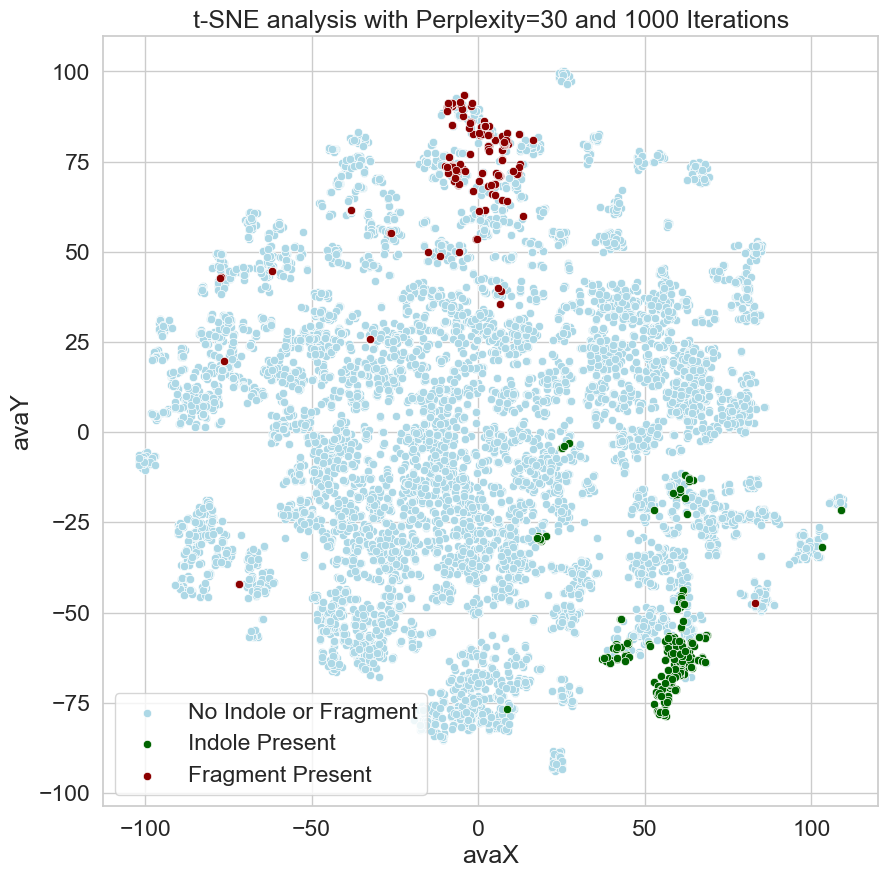

In [78]:
# Desired number of iterations
n_iter_value = 1000
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

1500 steps.

CPU times: total: 7min 37s
Wall time: 1min 21s
        avaX       avaY  Has_Indole  Has_Fragment
0 -28.751186  30.292389           0             0
1  70.077698 -86.360146           1             0
2  70.445435 -86.747673           1             0
3  72.140091 -79.286865           1             0
4 -25.506731  28.624037           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


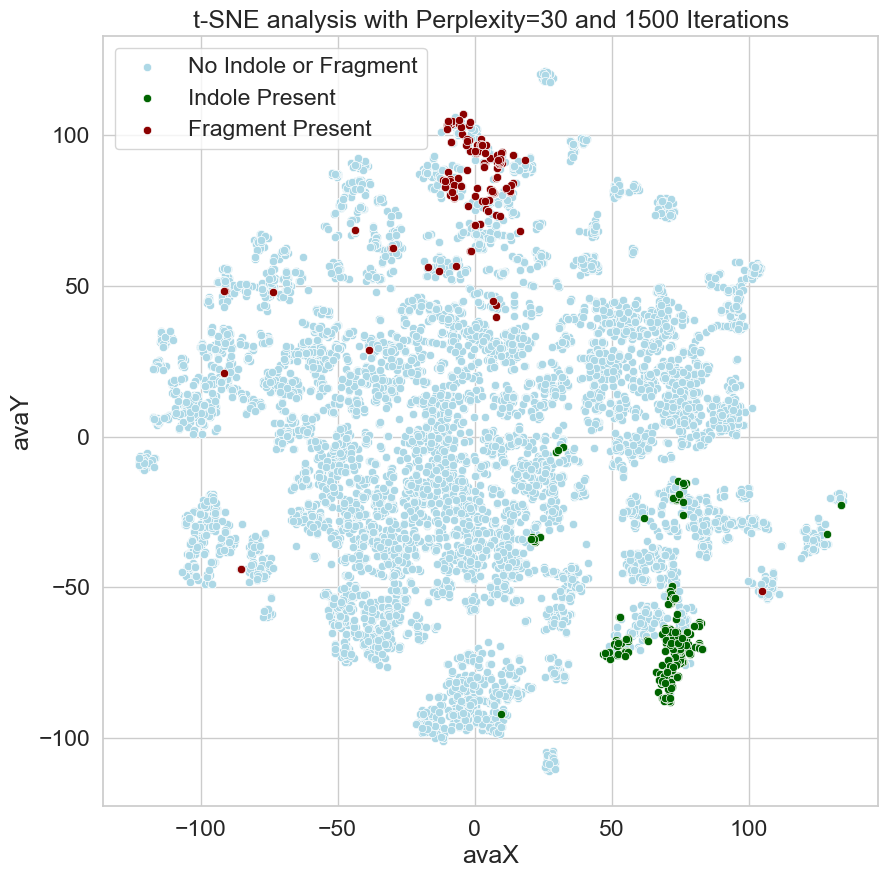

In [79]:
# Desired number of iterations
n_iter_value = 1500
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

2000 steps.

CPU times: total: 14min 39s
Wall time: 2min 46s
        avaX       avaY  Has_Indole  Has_Fragment
0 -31.926569  31.553535           0             0
1  77.160080 -91.698486           1             0
2  77.612381 -92.139702           1             0
3  79.395470 -84.058540           1             0
4 -28.564093  29.732676           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


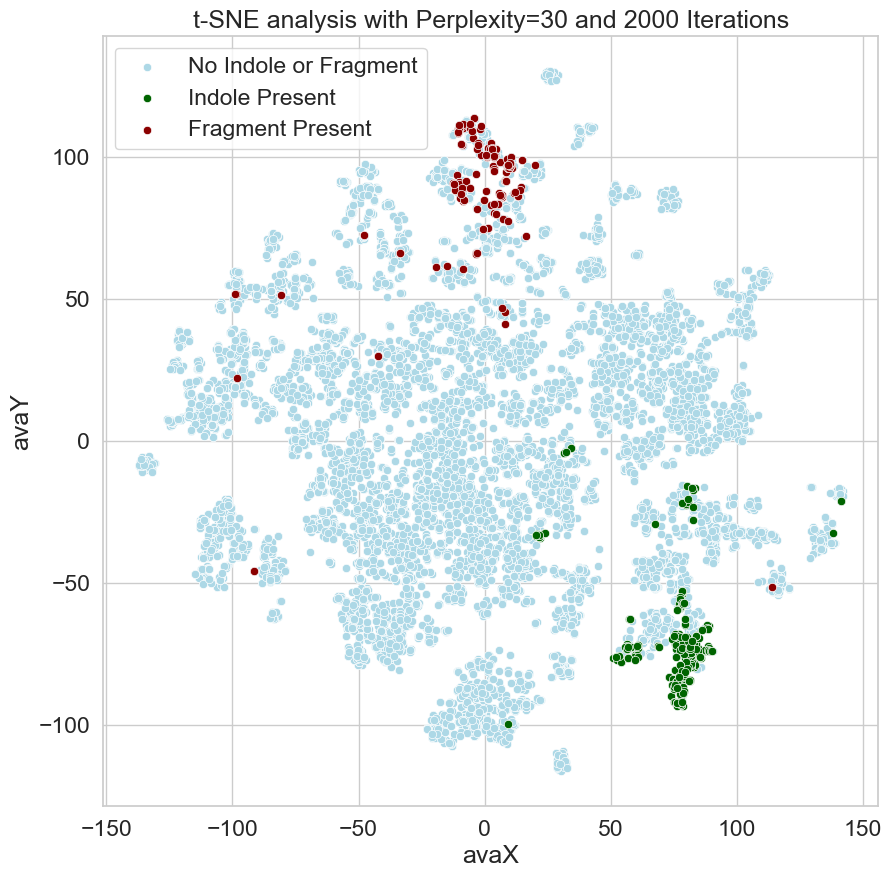

In [80]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

5000 steps.

CPU times: total: 33min 56s
Wall time: 6min 1s
        avaX        avaY  Has_Indole  Has_Fragment
0 -38.555904   37.390469           0             0
1  96.327217 -108.796394           1             0
2  97.078842 -109.200859           1             0
3  97.912704 -100.255531           1             0
4 -34.289036   36.438015           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


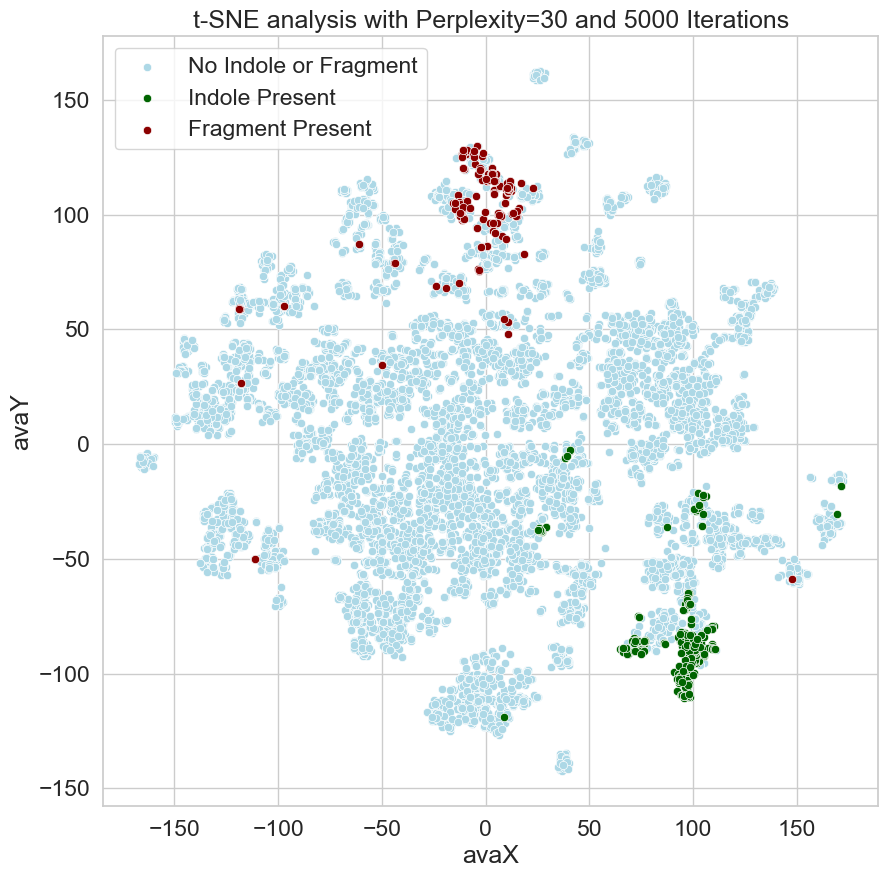

In [81]:
# Desired number of iterations
n_iter_value = 5000
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')
plt.show()

250 steps and perplexity = 2 (changing perplexity).

CPU times: total: 2min 8s
Wall time: 26.6 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -2.075660  3.094992           0             0
1  7.058968  0.781554           1             0
2  7.083914  0.799964           1             0
3  6.368756 -2.714669           1             0
4 -1.937278  3.231422           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


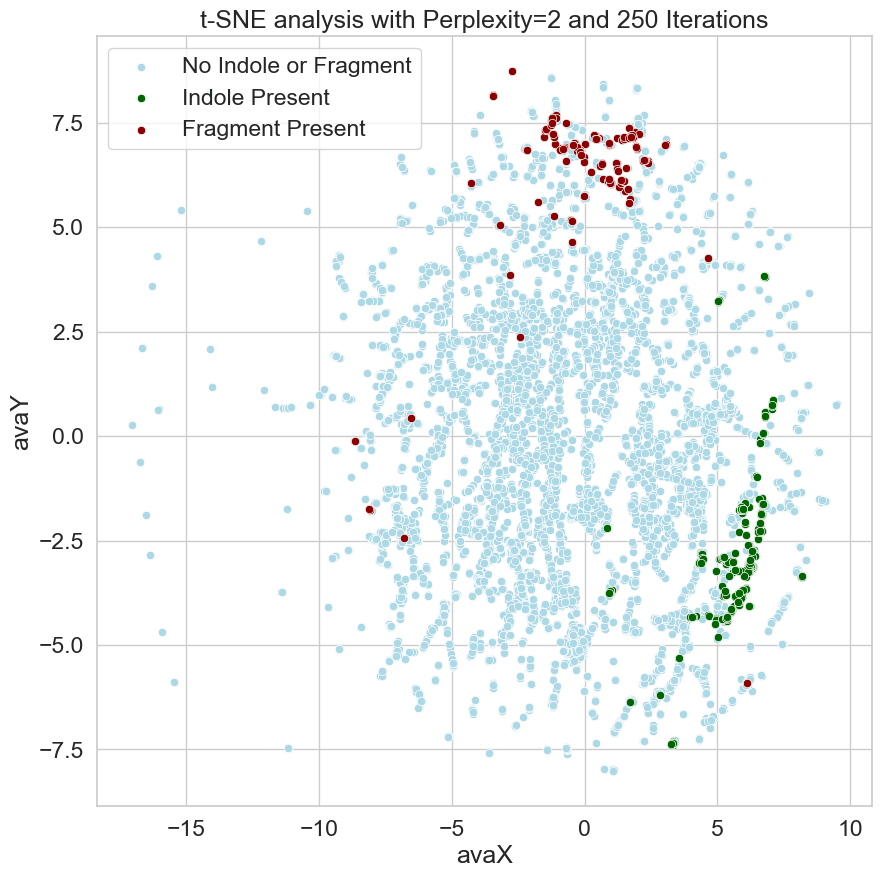

In [97]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 2

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

250 steps and perplexity = 5 (changing perplexity).

CPU times: total: 1min 16s
Wall time: 14.2 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -2.336347  2.040653           0             0
1  6.622652 -2.828314           1             0
2  6.632255 -2.824174           1             0
3  5.961072 -3.307476           1             0
4 -2.211530  2.001953           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


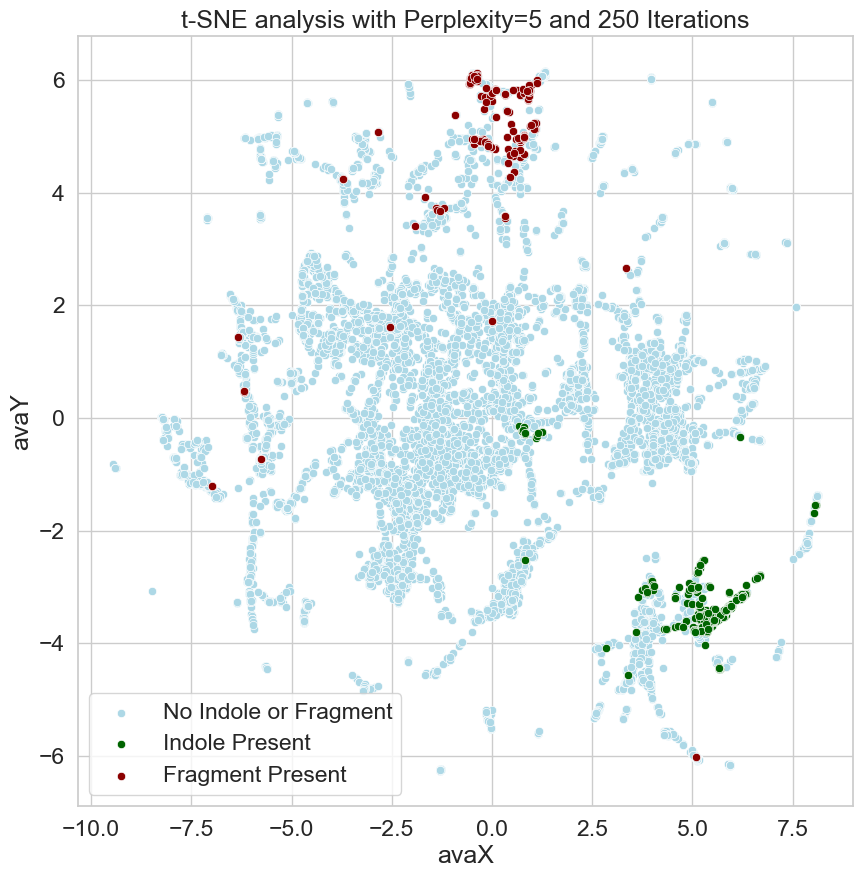

In [109]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 5

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

250 steps and perplexity = 10 (changing perplexity).

CPU times: total: 1min 24s
Wall time: 16.8 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -1.819993  1.471695           0             0
1  5.725937 -2.916870           1             0
2  5.723272 -2.916736           1             0
3  5.245105 -2.825485           1             0
4 -1.768189  1.391744           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


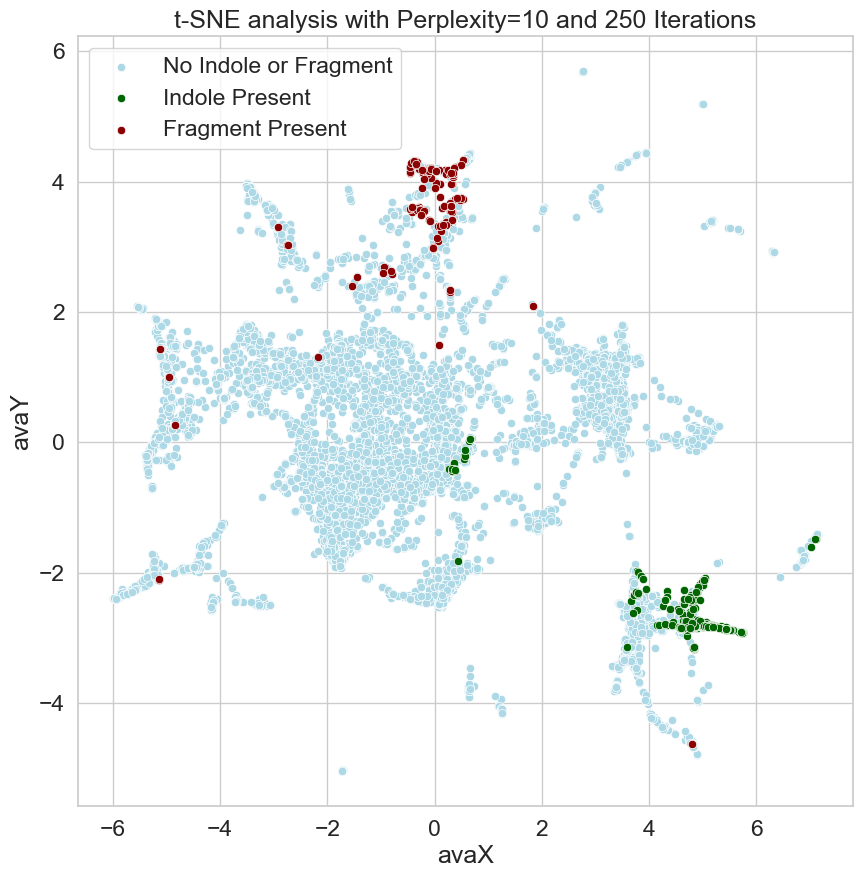

In [110]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 10

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

250 steps and perplexity = 30 (changing perplexity).

CPU times: total: 1min 55s
Wall time: 21.5 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -0.932778  0.684376           0             0
1  3.288145 -1.808127           1             0
2  3.286319 -1.808683           1             0
3  3.281198 -1.703010           1             0
4 -0.960443  0.596721           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


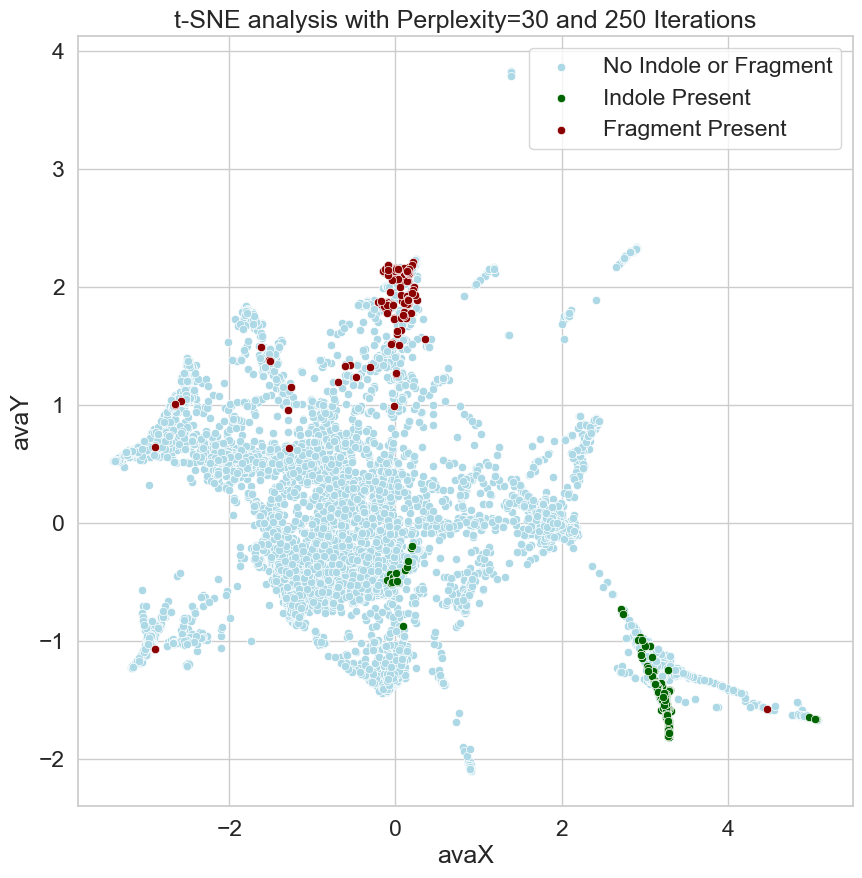

In [111]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

250 steps and perplexity = 100 (changing perplexity).

CPU times: total: 3min 2s
Wall time: 33.5 s
       avaX      avaY  Has_Indole  Has_Fragment
0 -0.322468  0.259665           0             0
1  1.759232 -0.101910           1             0
2  1.753141 -0.100060           1             0
3  1.803578 -0.106668           1             0
4 -0.369559  0.193788           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


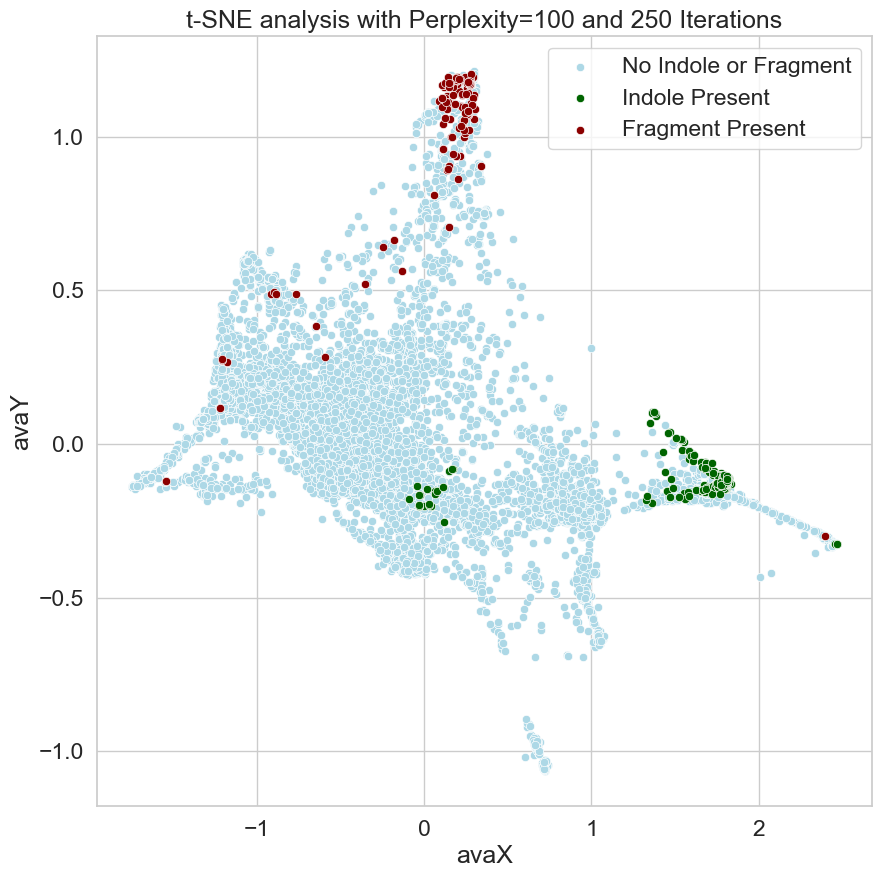

In [112]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 100

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

250 steps and perplexity = 400 (changing perplexity).

CPU times: total: 5min 42s
Wall time: 1min 10s
       avaX      avaY  Has_Indole  Has_Fragment
0 -0.105863  0.029264           0             0
1  0.518533 -0.098685           1             0
2  0.515901 -0.095775           1             0
3  0.546606 -0.103944           1             0
4 -0.115270  0.011664           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


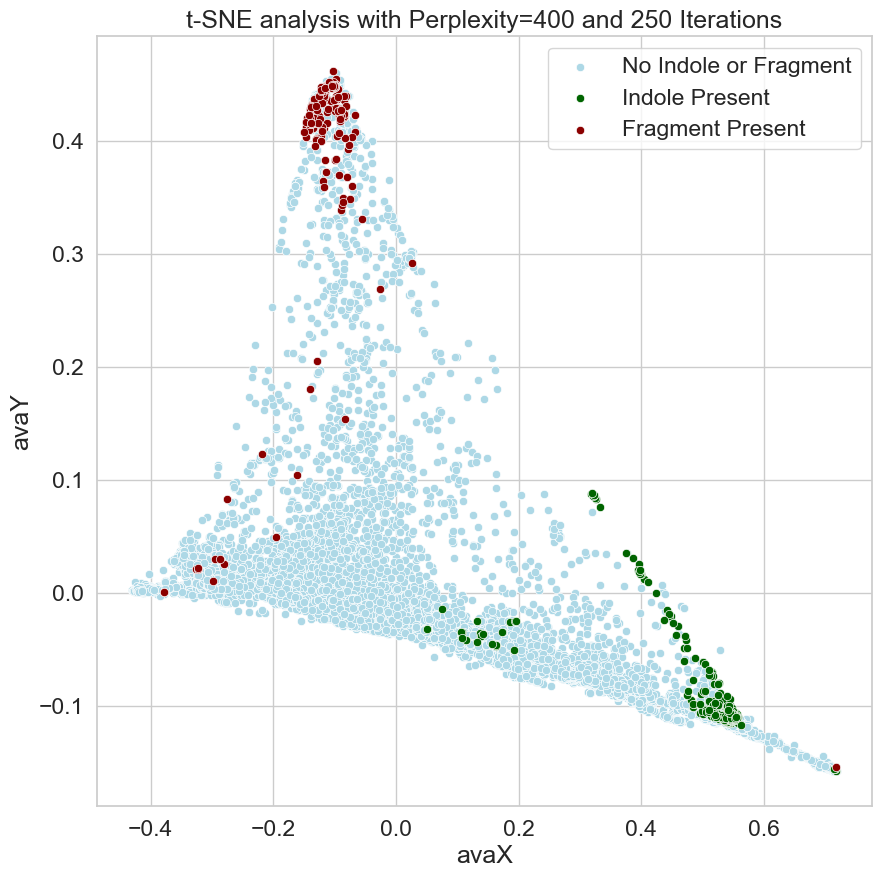

In [113]:
# Desired number of iterations
n_iter_value = 250
perplexity_value = 400

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 11min 40s
Wall time: 2min 13s
         avaX       avaY  Has_Indole  Has_Fragment
0  -43.509075  63.189770           0             0
1  138.970840  19.999840           1             0
2  137.770386  16.252678           1             0
3  128.066940 -54.936775           1             0
4  -41.108990  81.705605           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


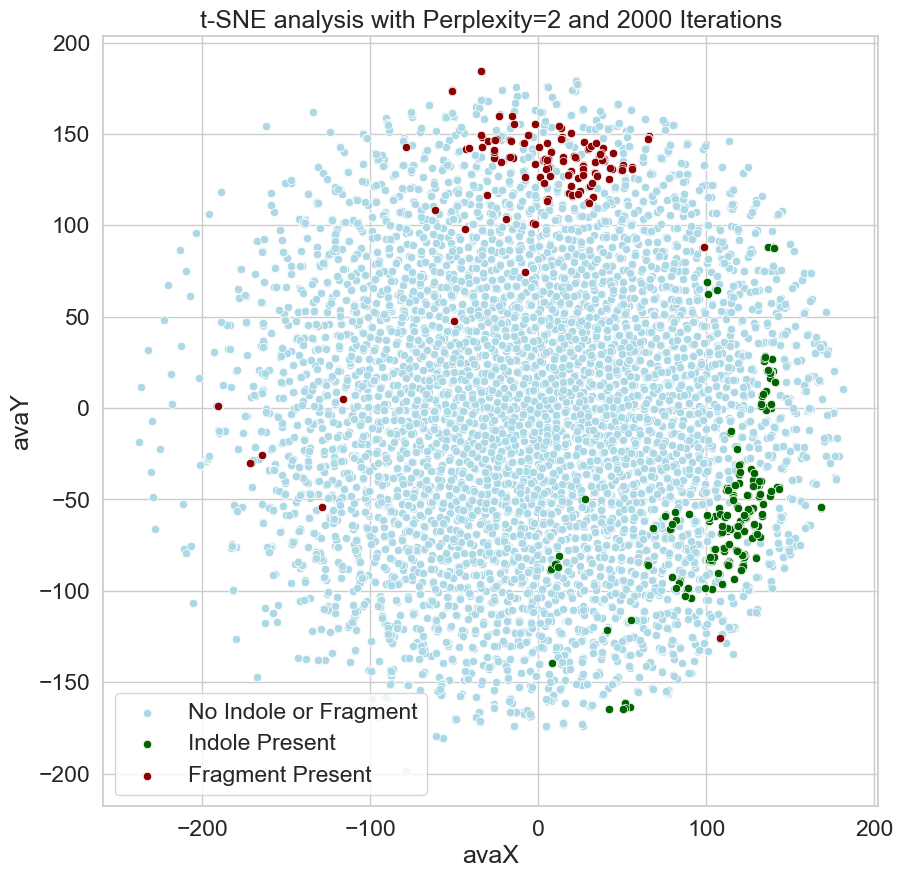

In [114]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 2

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 11min 6s
Wall time: 2min 3s
         avaX       avaY  Has_Indole  Has_Fragment
0  -47.606319  63.608349           0             0
1  133.871826 -51.519741           1             0
2  132.301071 -51.998283           1             0
3  130.160538 -79.051514           1             0
4  -43.931587  72.121559           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


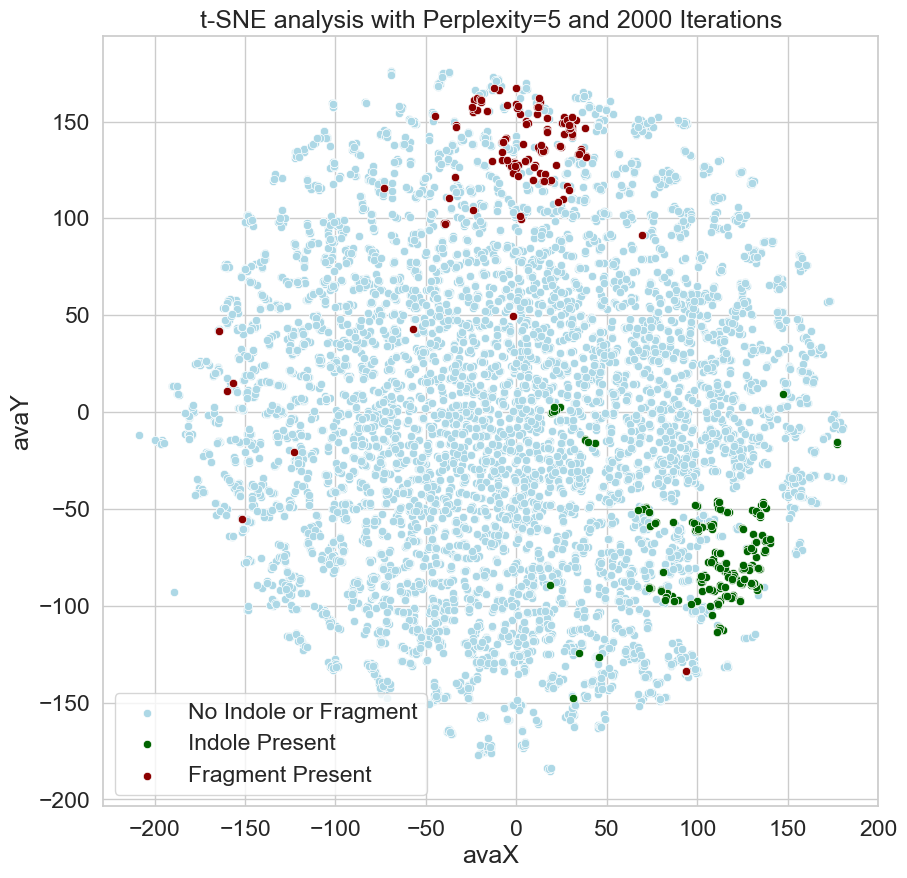

In [115]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 5

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 11min 33s
Wall time: 2min 11s
         avaX       avaY  Has_Indole  Has_Fragment
0  -40.846786  62.516304           0             0
1  148.244644 -68.986862           1             0
2  148.145340 -68.084633           1             0
3  131.639374 -70.445045           1             0
4  -35.931469  65.959564           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


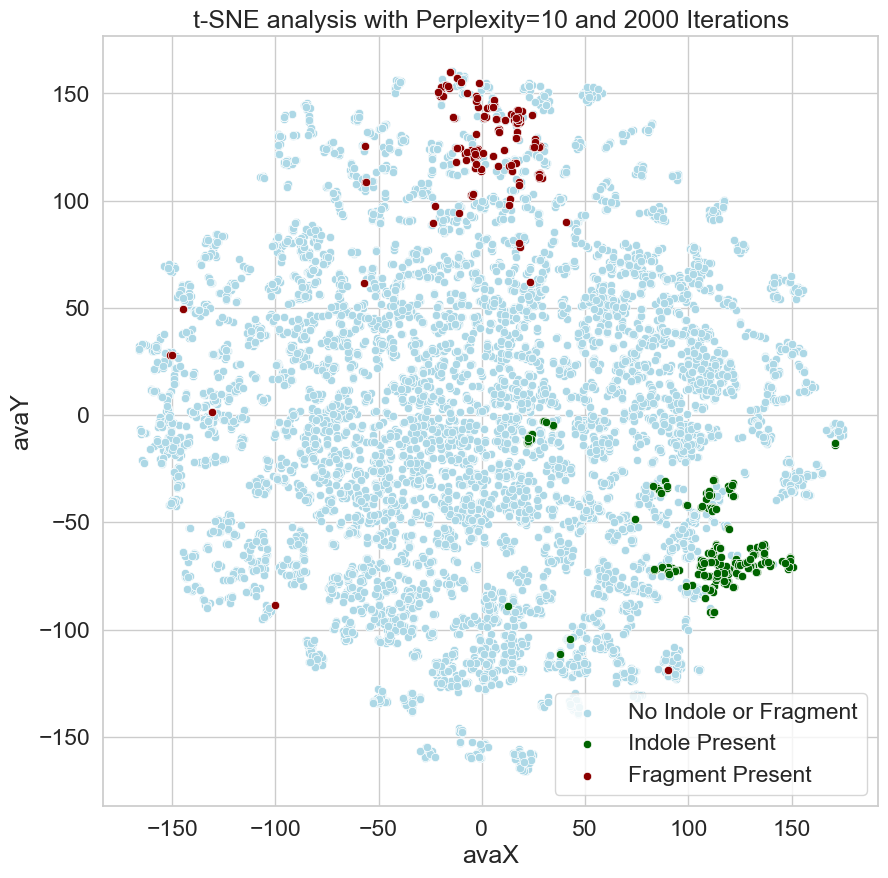

In [116]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 10

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 14min 9s
Wall time: 2min 22s
        avaX       avaY  Has_Indole  Has_Fragment
0 -31.481665  31.785110           0             0
1  78.276299 -92.774269           1             0
2  78.771423 -93.186600           1             0
3  80.374527 -85.482071           1             0
4 -27.998495  29.981628           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


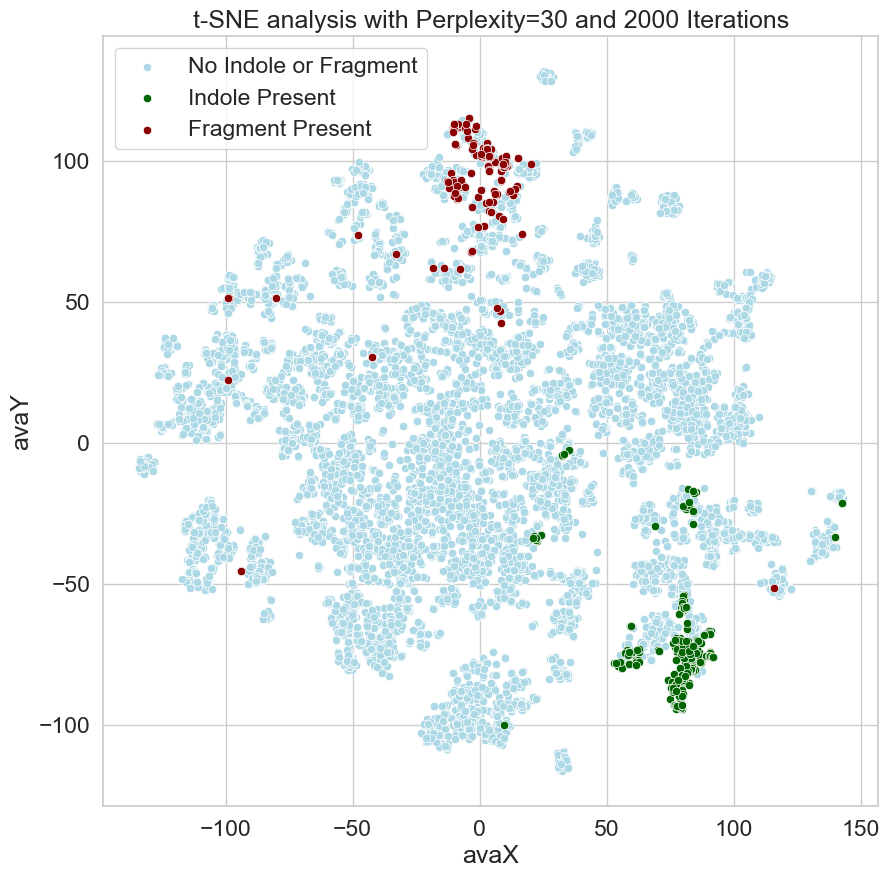

In [117]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 30

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 22min 15s
Wall time: 3min 47s
        avaX       avaY  Has_Indole  Has_Fragment
0 -18.638155  24.097712           0             0
1  76.391418  38.797710           1             0
2  76.032738  38.927486           1             0
3  78.481010  35.857761           1             0
4 -19.688435  20.766430           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


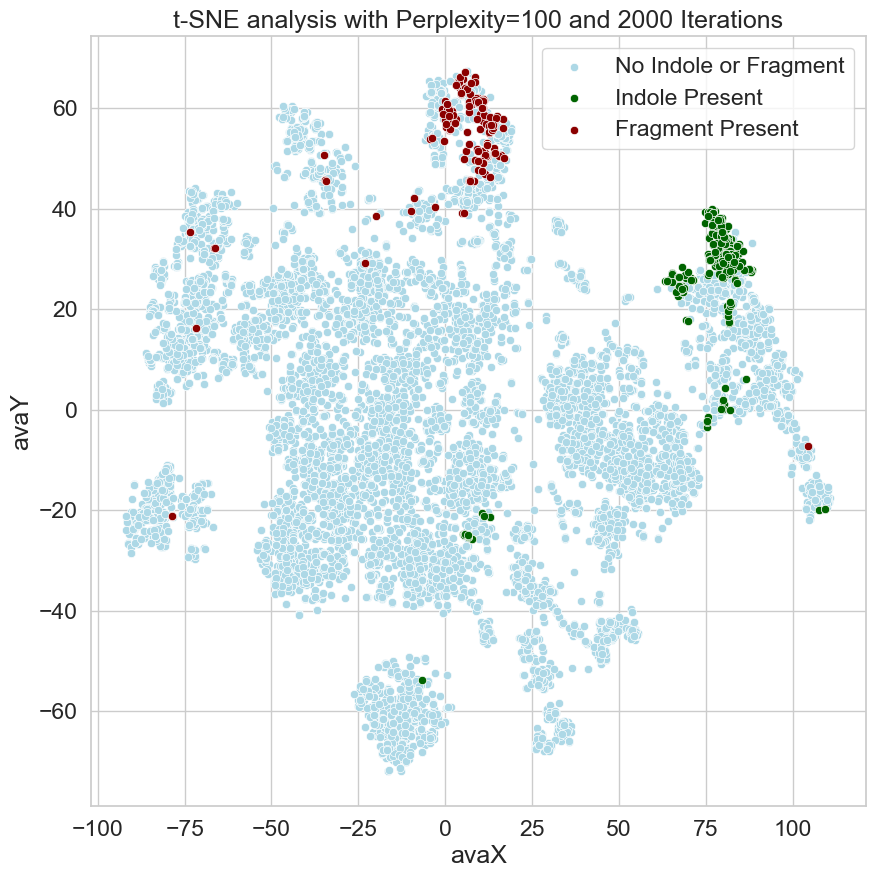

In [118]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 100

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

CPU times: total: 43min 15s
Wall time: 8min 14s
        avaX       avaY  Has_Indole  Has_Fragment
0 -13.183435  16.632685           0             0
1  38.547039  14.878735           1             0
2  38.416321  14.896336           1             0
3  39.353600  13.296298           1             0
4 -12.081181  16.050980           0             0
'Has_Indole' is true 331 times.
'Has_Fragment' is true 196 times.


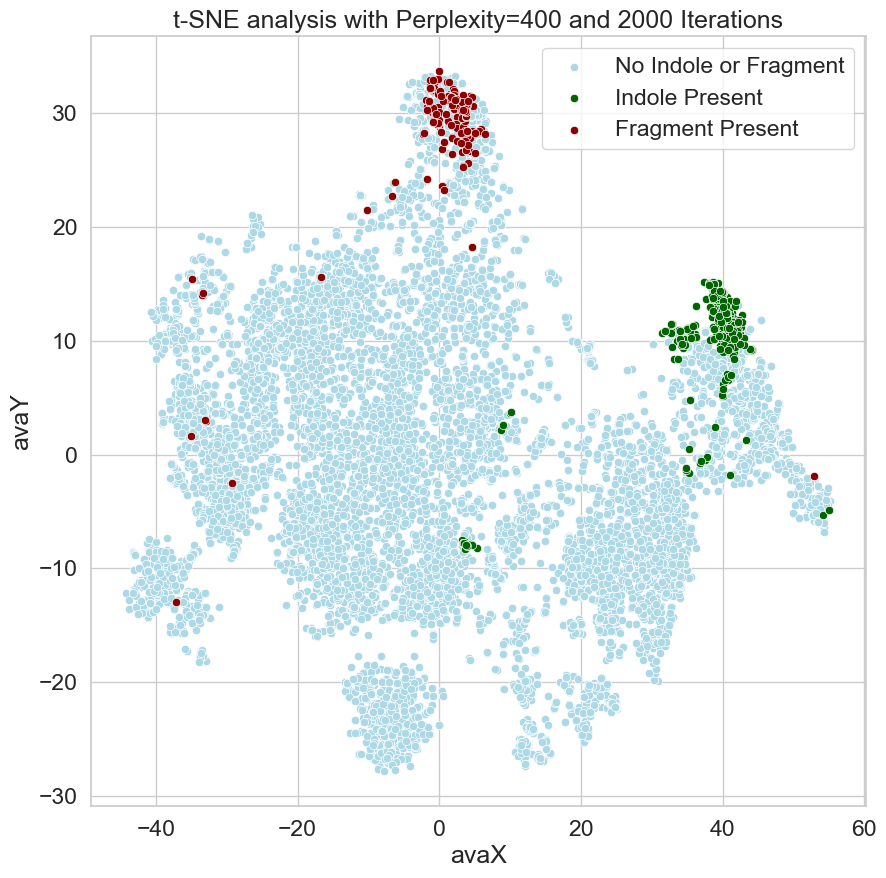

In [119]:
# Desired number of iterations
n_iter_value = 2000
perplexity_value = 400

%time avacrds_embedded = TSNE(n_components=2, perplexity=perplexity_value, n_iter=n_iter_value).fit_transform(avacrds)

# Put the t-sne dataset into a dataframe to simplify plotting 
avatsne_df = pd.DataFrame(avacrds_embedded,columns=["avaX","avaY"])

# Drop rows with NaN values from 'Has_Indole' and 'Has_Fragment' column and convert to integer
has_indole_values = df['Has_Indole'].dropna().astype(int)
has_fragment_values = df['Has_Fragment'].dropna().astype(int)

# Add the integer values to avacrds_df
avatsne_df['Has_Indole'] = has_indole_values.tolist()
avatsne_df['Has_Fragment'] = has_fragment_values.tolist()

# Print the DataFrame
print(avatsne_df.head())

# Calculate and print the count of True (1) values for 'Has_Indole' and 'Has_Fragment
count_has_indole = avatsne_df['Has_Indole'].sum()
count_has_fragment = avatsne_df['Has_Fragment'].sum()

print(f"'Has_Indole' is true {count_has_indole} times.")
print(f"'Has_Fragment' is true {count_has_fragment} times.")

#Plot the results
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 0"),x="avaX",y="avaY",color='lightblue')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Indole == 1"),x="avaX",y="avaY",color='darkgreen')
avaax = sns.scatterplot(data=avatsne_df.query("Has_Fragment == 1"),x="avaX",y="avaY",color='darkred')

# Add legend
_ = plt.legend(labels=['No Indole or Fragment', 'Indole Present', 'Fragment Present'])

# Plot title
plt.title(f't-SNE analysis with Perplexity={perplexity_value} and {n_iter_value} Iterations')

# Save the plot as SVG file
filename = f'tSNE_avalon_perplexity_{perplexity_value}_step_{n_iter_value}.svg'
plt.savefig(filename, format='svg')
plt.show()

In [107]:
output_ava_tsne_df = pd.concat([df["Name"], avacrds_df[["avaPC_1","avaPC_2"]],avatsne_df[["avaX","avaY"]],axis=1)
output_ava_tsne_df.head()

Name   morPC_1   morPC_2       morX       morY   avaPC_1   avaPC_2  \
0   Bivalirudin  2.539088 -0.555063 -20.853830 -88.409492  0.805624  2.128606   
1    Leuprolide  3.290432  0.159194 -26.087456 -88.513695  8.233128 -1.444422   
2     Goserelin  3.175423  0.336041 -26.570332 -88.701363  8.922778 -0.207221   
3  Gramicidin D  1.285003 -0.873331 -30.506905 -78.056374  5.426151 -0.086389   
4  Desmopressin  2.396483 -0.080431 -42.266457 -70.162010  0.289790 -0.578004   

        avaX       avaY   ttoPC_1   ttoPC_2       ttoX       ttoY  maccsPC_1  \
0 -23.338179  25.389338  3.714470  1.728447  37.895958  68.440071   2.257830   
1  51.959785 -74.103310  4.143136  2.051997  42.714577  69.180595   2.750004   
2  51.598835 -74.046066  3.959680  1.879855  43.038147  69.083946   3.066457   
3  56.469410 -69.095177  2.830334  1.555354  44.601707  65.469048   0.920247   
4 -21.334366  23.306152  2.887252  0.868575  36.677002  69.585213   2.395233   

   maccsPC_2     maccsX     maccsY  
0  -1.863216  53.770695  11.144918  
1  -1.925191  55.901806  11.487069  
2  -2.156118  56.775791  12.662444  
3  -1.057296  33.082027   9.590095  
4  -1.122772  55.517921   8.163020

Write the dataframe to a csv file.  Note that we set "index=False" to avoid writling line numbers to the csv file.

In [108]:
output_ava_tsne_df.to_csv("../Metrics/dude_erk2_mk01_tnse.csv",index=False)